Тема 6. Сплайны

1) Эрмитовы кубические сплайны

Пусть там дано какое-то разбиение/сетка необязательно равномерное с $N$ узлами, а также мы знаем значение функции и производной первого порядка этой функции в каждом из узлов разбиения. 

Опр. Эрмитовым кубическим сплайном называют функцию $S(x)$, удовлетворяющую условиям:

- $S(x) \in P_{3i}(x)$ для любого $x \in [x_i, x_{i + 1}], \ i = \overline{0, N-1}$ (по сути говорим, что $S(x)$ полином третьей степени)
- $S(x) \in C^1_{[a, b]}$, здесь $a$ и $b$ - начало и конец сетки соответственно
- $S(x_i) = f(x_i), \ S'(x_i) = f'(s_i), \ i = \overline{0, N}$

Эрмитовы сплайны являются локальными (используются только ближайшие узлы). Для их вычисления на отрезке $[x_i; x_{i+1}]$ достаточно использовать третье условие определения: 

$S(x_i) = y_i, \quad S'(x_i) = y'_i, \quad S(x_{i+1}) = y_{i + 1}, \quad S'(x_{i + 1}) = y'_{i + 1}$

Тогда $S(x)$ на отрезке $[x_i, x_{i+1}]$ можно записать как:

$\displaystyle S(x_{i + 1}) = y_i + y'_{i}(x - x_i) + a_i\frac{(x-x_i)^2}{2} + b_i\frac{(x-x_i)^3}{6}$,

где

$\displaystyle a_i = \frac{6}{h_{i + 1}} \left[ -\frac{2y'_{i}+y'_{i+1}}{3} + \frac{y_{i + 1} - y_i}{h_{i + 1}}\right], \quad b_i = \frac{12}{h^2_{i + 1}} \left[\frac{y'_i + y'_{i + 1}}{2} - \frac{y_{i + 1} - y_i}{h_{i + 1}} \right] $

за $h_{i + 1}$ обозначен шаг $(x_{i + 1} - x_i)$, хотя обычно его обозначают как $h_i$, но я решил не отходить от методички

Короче, как я понял начальные условия мы почти из воздуха взяли и вот решили с их помощью построить кубический полином вида 

$S(x) = A + B(x - x_i) + C(x - x_i)^2 + D(x - x_i)^3 \quad (1)$

Почему кубический? Потому что у нас есть 4 стратовых условия, которым мы должны удовлетворить (значения в точках и значения производных), а для этого нам нужно не меньше 4-х коэффициентов, а больше и смысла брать не то чтобы много.

Почему именно в таком виде? А потому что это распиаренная в математическом мире и *удобная* форма записи, называемая сдвинутой или локальной полиномиальной формой.

Есть еще другая запись полинома с использованием базиса Эрмита $S(x) = H_1(x)y_i + H_2(x)y' + H_3(x)y_{i + 1} + H_4(x)y'_{i + 1}$. Записи эквивалентны.

Возвращаясь к записи (1) и удовлетворениям 4-ем стартовым условиям

- $S(x_i) = A = y_i$
- $S'(x_i) = B = y'_i$
- $S(x_{i + 1}) = A + Bh + Ch^2 + Dh^3 = y_{i + 1}$
- $S'(x_{i + 1}) = B + 2Ch + 3Dh^2 = y'_{i + 1}$

Тут $A,\ B,\ C$ и $D$ просто коэффициенты, которые подбираются/находятся под эти условия. Ну и понятно, что $\displaystyle \frac{a_i}{2} = C, \ \frac{b_i}{6} = D$

$a_i$ и $b_i$ выражаются из системы 

$\begin{cases}
S(x_{i + 1}) = y_{i + 1}\\
S'(x_{i + 1}) = y'_{i + 1}
\end{cases}$

In [18]:
import numpy as np

class CubicHermiteSpline:
    def __init__(self, x: np.ndarray, y: np.ndarray, dy: np.ndarray):
        """Функция инициализации Эрмитова Сплайна (подсчет коэффициентов)

        Args:
            x (np.ndarray): абсциссы узлов
            y (np.ndarray): Ординаты узлов
            dy (np.ndarray): производные в узлах
        """
        self.x = np.array(x)
        self.y = np.array(y)
        self.dy = np.array(dy)
        self.n = len(x) - 1

        self.h = self.x[1:] - self.x[:-1]
        self.a = np.zeros(self.n)
        self.b = np.zeros(self.n)

        for i in range(self.n):
            hi = self.h[i]
            self.a[i] = (6 / hi) * (-(2 * self.dy[i] + self.dy[i+1]) / 3 + (self.y[i+1] - self.y[i]) / hi)
            self.b[i] = (12 / hi**2) * ((self.dy[i] + self.dy[i+1]) / 2 - (self.y[i+1] - self.y[i]) / hi)

    def __call__(self, x_val: np.ndarray) -> np.ndarray:
        """Подсчет значения с использованием ранее полученных коэффицентов сплайнов

        Args:
            x_val (np.ndarray): Массив точек, в которых нужно найти значение (можно передать скаляр)

        Returns:
            np.ndarray: Значение в точке (если переданное значение скаляр, то вернутся скалярное значение)
        """
        scalar_input = np.isscalar(x_val)
        x_val = np.atleast_1d(x_val)

        result = np.zeros_like(x_val, dtype=float)

        for idx, x in enumerate(x_val):
            i = np.searchsorted(self.x, x) - 1
            i = np.clip(i, 0, self.n - 1)

            dx = x - self.x[i]
            yi = self.y[i]
            dyi = self.dy[i]
            ai = self.a[i]
            bi = self.b[i]

            result[idx] = yi + dyi * dx + ai * dx**2 / 2 + bi * dx**3 / 6

        return result[0] if scalar_input else result


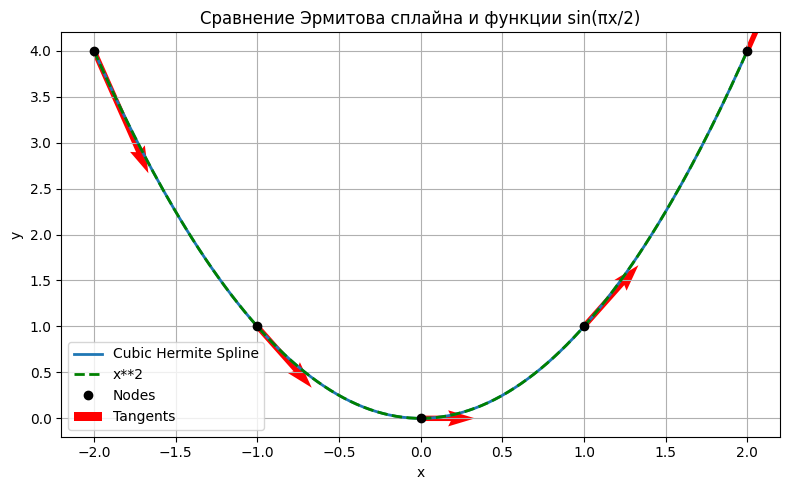

In [19]:
import matplotlib.pyplot as plt

x = [-2, -1, 0, 1, 2]
y = [4, 1, 0, 1, 4]
dy = [-4, -2, 0, 2, 4]
func = lambda x: x**2
spline = CubicHermiteSpline(x, y, dy)

x_dense = np.linspace(-2, 2, 200)
y_dense = spline(x_dense)
y_true_dense = func(x_dense)

plt.figure(figsize=(8, 5))
plt.plot(x_dense, y_dense, label='Cubic Hermite Spline', linewidth=2)
plt.plot(x_dense, y_true_dense, label=r'x**2', linestyle='--', linewidth=2, color='green')
plt.plot(x, y, 'o', label='Nodes', color='black')
plt.quiver(x, y, np.ones_like(dy), dy, angles='xy', scale_units='xy', scale=3, color='red', label='Tangents')

plt.title('Сравнение Эрмитова сплайна и функции sin(πx/2)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


2) Кубические нелокальные сплайны

Первое отличие от локальных Эрмитовых сплайнов, очевидно, зависимость от большего числа узлов (чаще всего строиться по всем узлам сетки).

Второе отличие это то, что производные нам не даются заранее, а только требуем, чтобы они были непрерывны, после мы вычисляем их в процессе решая СЛАУ.

Что мы конкретно требуем:

- $S_i = f_i$
- $S_i(x_{i + 1}) = f_{x + 1}$
- $S'_i(x_{i + 1}) = S'_{i + 1}(x_{i + 1})$
- $S''_i(x_{i + 1}) = S''_{i + 1}(x_{i + 1})$

Получаем систему уравнений на вторых производных, но есть нюанс.

Если подумать, то у нас получается по 4 коэффициента на каждый $S(x)$ и если учитывать, что мы строим $S$ на каждый из интервалов сетки, то мы получаем $4N$ неизвестных коэффициентов, которые нам нужно найти, а искать мы их собирались из СЛАУ.

Допустим мы получим $N + 1$ равенство из условия $S(x_i) = f_i$, но вот непрерывность распространяется только на внутренние узлы, то есть непрерывность в каждом из внутренных узлов даст нам только $N - 1$ уравнение (отняли крайние узлы $x_0$ и $x_N$), плюсом еще $2(N - 1)$ уравнения с непрерывности первой и второй производной. Итого получили $4N - 2$ уравнения при $4N$ неизвестных, что не позволяет однозначно определить коэффициенты.

Для этого и нужны краевые условия, чтобы получить дополнительные парочку уравнений, например: $\displaystyle S''(x_0) = S''(x_N) = 0$

В общем это все конечно круто, но было бы неплохо понять, что там вообще за уравнения получаются.

- На каждом интервале $[x_i,\ x_{i + 1}],\ i = \overline{0, N-1}$, мы предполагаем, что $S(x)$ - кубический полином вида:

$S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3$

Всего у нас $N$ таких интервалов и следовательно $4N$ коэффициентов: $a_i,\ b_i,\ c_i,\ d_i,\ i = \overline{0, N-1}$

- Дальше два заданных условия: 

Первое - в начале каждого интервала сплайн должен проходить через точку $y_i$, т.е. $S_i(x_i) = y_i \rightarrow a_i = y_i$

Второе - в конце каждого интервала сплайн должен проходить через точку $y_{i + 1}$, т.е. $S_i(x_{i + 1}) = y_{i + 1} \rightarrow a_i + b_ih_i + c_ih_i^2 + d_ih_i^3 = y_{i + 1}$

$h_i = x_{i + 1} - x_i$

Это $2N$ уравнений из СЛАУ

Далее, так как мы предполагаем гладкость сплайна вплоть до второй производной:

$S'_i(x) = b_i + 2c_i(x - x_i) + 3d_i(x - x_i)^2$

$S''_i(x) = 2c_i + 6d_i(x - x_i)$

Ну и пользуемся условием, что $S'_i(x_{i + 1}) = S'_{i + 1}(x_{i + 1})$ и $S''_i(x_{i + 1}) = S''_{i + 1}(x_{i + 1}), \ i = \overline{0, N-2}$

Из условия с первой производной получим $N - 1$ уравнение вида $b_i + 2c_ih_i + 3d_ih^2_i = b_{i + 1}$

Из условия со второй производной получим $N - 1$ уравнение вида $2c_i + 6d_ih_i = 2c_{i + 1}$

Итого на данном этапе у нас получились те самые $4N - 2$ уравнения, добавляем к ним уравнения с краевыми условиями и либо втупую решаем полученную систему в поисках коэффициентов, либо пользуемся переводом в систему для вторых производных и решаем через прогонки.

In [22]:
import numpy as np

def thomas_algorithm(A: np.ndarray, B: np.ndarray, C: np.ndarray, F: np.ndarray) -> np.ndarray:
    """
    Решает трехдиагональную систему линейных уравнений методом прогонки (методом Томаса).

    Args:
        A (np.ndarray): Коэффициенты поддиагонали, при этом A[0] не используется или равен 0.
        B (np.ndarray): Коэффициенты главной диагонали.
        C (np.ndarray): Коэффициенты наддиагонали, при этом C[N-1] не используется или равен 0.
        F (np.ndarray): Вектор правой части.

    Returns:
        np.ndarray: Соответсвуюший вектор решений U, удовлетворяющий системе.
    """
    N = len(B)
    alpha = np.zeros(N)
    beta = np.zeros(N)
    U = np.zeros(N)

    if B[0] == 0:
        raise ZeroDivisionError("Нулевой элемент на главной диагонали: B[0] == 0")
    alpha[1] = -C[0] / B[0]
    beta[1] = F[0] / B[0]

    for k in range(1, N - 1):
        denom = B[k] + A[k] * alpha[k]
        if denom == 0:
            raise ZeroDivisionError(f"Деление на ноль при k={k}, знаменатель обращается в ноль.")
        alpha[k + 1] = -C[k] / denom
        beta[k + 1] = (F[k] - A[k] * beta[k]) / denom

    denom = A[N - 1] * alpha[N - 1] + B[N - 1]
    if denom == 0:
        raise ZeroDivisionError("Деление на ноль при вычислении последнего элемента.")
    U[N - 1] = (F[N - 1] - A[N - 1] * beta[N - 1]) / denom

    for k in range(N - 2, -1, -1):
        U[k] = alpha[k + 1] * U[k + 1] + beta[k + 1]

    return U


In [27]:
import numpy as np

class CubicSpline:
    def __init__(self, x, y):
        """Функция инициализации нелокального сплайна(подсчет коэффициентов)

        Args:
            x (np.ndarray): абсциссы узлов
            y (np.ndarray): ординаты узлов
        """
        self.x = np.array(x, dtype=float)
        self.y = np.array(y, dtype=float)
        self.n = len(x) - 1
        self.h = np.diff(self.x)

        # A = np.zeros((self.n + 1, self.n + 1))
        rhs = np.zeros(self.n + 1)

        # A[0, 0] = 1
        # A[self.n, self.n] = 1
        rhs[0] = 0
        rhs[self.n] = 0
        A1 = np.zeros(self.n + 1)
        A2 = np.zeros(self.n + 1)
        A3 = np.zeros(self.n + 1)
        A2[0] = 1
        A2[self.n] = 1
        
        for i in range(1, self.n):
            A1[i] = self.h[i - 1]
            A2[i] = 2 * (self.h[i - 1] + self.h[i])
            A3[i] = self.h[i]

            rhs[i] = 6 * ((self.y[i + 1] - self.y[i]) / self.h[i] - (self.y[i] - self.y[i - 1]) / self.h[i - 1])

        self.M = thomas_algorithm(A1, A2, A3, rhs)

        self.coeffs = []
        for i in range(self.n):
            hi = self.h[i]
            a = self.y[i]
            b = (self.y[i + 1] - self.y[i]) / hi - (hi / 6) * (2 * self.M[i] + self.M[i + 1])
            c = self.M[i] / 2
            d = (self.M[i + 1] - self.M[i]) / (6 * hi)
            self.coeffs.append((a, b, c, d))

    def __call__(self, x_val: np.ndarray) -> np.ndarray:
        """Функция подсчета значения в точках с ипользованием полученных ранее коэффициентов сплайнов

        Args:
            x_val (np.ndarray): массив точек (можно передать просто скаляр)

        Returns:
            np.ndarray: массив значений (если входные данные скаляр, то на выходе будет скаляр)
        """
        x_val = np.atleast_1d(x_val)
        result = np.zeros_like(x_val, dtype=float)

        for idx, x in enumerate(x_val):
            i = np.searchsorted(self.x, x) - 1
            if i < 0:
                i = 0
            elif i >= self.n:
                i = self.n - 1

            dx = x - self.x[i]
            a, b, c, d = self.coeffs[i]
            result[idx] = a + b * dx + c * dx**2 + d * dx**3

        return result if result.shape[0] > 1 else result[0]


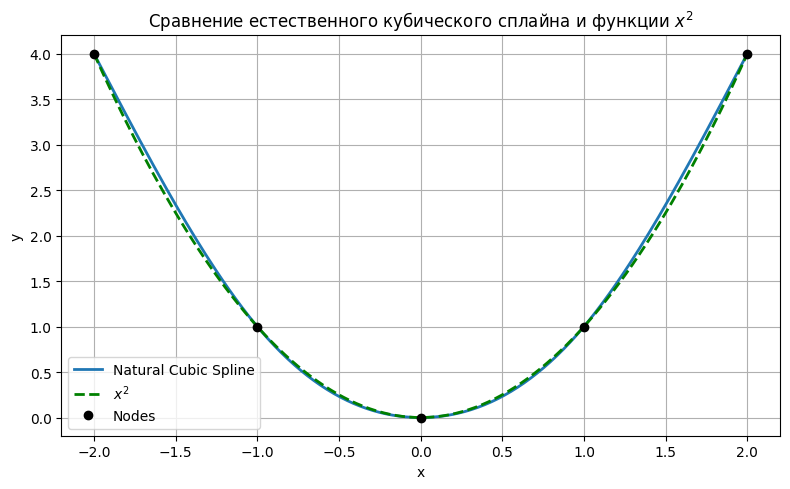

In [28]:
import numpy as np
import matplotlib.pyplot as plt

x = [-2, -1, 0, 1, 2]
y = [4, 1, 0, 1, 4]

func = lambda x: x**2

spline = CubicSpline(x, y)

x_dense = np.linspace(-2, 2, 200)
y_dense = spline(x_dense)
y_true_dense = func(x_dense)

plt.figure(figsize=(8, 5))
plt.plot(x_dense, y_dense, label='Natural Cubic Spline', linewidth=2)
plt.plot(x_dense, y_true_dense, label=r'$x^2$', linestyle='--', linewidth=2, color='green')
plt.plot(x, y, 'o', label='Nodes', color='black')

plt.title('Сравнение естественного кубического сплайна и функции $x^2$')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


3) Построение кубического сплайна через наклоны

Судя по методичке, это дефолтный локальный Эрмитов сплайн, только производные в узлах обозначаются как $m_i$, что является либо реальным значением производной, либо аппрокимированным значением + в методичке описан процесс вывода $a_i$ и $b_i$, но там вроде ничего сверхестественного.

В случае, если $m_i$ никак не задаются, то в методичке просто находят вторые производные слева и справа от каждого внутреннего узла, приравнивают их ссылаясь на непрерывность и получают благодяря этому $N - 1$ уравнение с $N + 1$ неизвестной $m_0,\ ...,\ m_N$ вида:

$\displaystyle \mu_{i}m_{i-1} + 2m_i + \lambda_{i}m_{i + 1} = 3\left(\lambda_i \frac{y_{i + 1} - y_i}{h_{i + 1}} + \mu_i \frac{y_i - y_{i - 1}}{h_i}\right), \quad i = \overline{1, N-1}$

где $\displaystyle \mu_i = \frac{h_{i + 1}}{h_i + h_{i + 1}}; \quad \lambda_i = 1 - \mu_i = \frac{h_i}{h_i + h_{i + 1}}; \quad \mu_i + \lambda_i = 1; h_{i + 1} = x_{i + 1} - x_i$, снова поменял обозначение шага :)

И потом используют какое-нибудь граничное условие, для добавления еще двух уравнений, например $\displaystyle S'(a) = y'(a); \ S'(b) = y'(b)$

4) Построение кубического сплайна через моменты

Аналогично пункту 3

5) Дифференцирование и интегрирование кубического сплайна

Тут тупо формулы